In [1]:
# default_exp loaders

# Datasets, DataLoaders, Samplers

In [2]:
# export

from pathlib import Path

import random
import numpy as np
import pandas as pd
from natsort import natsorted

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

In [3]:
# export
from lunglens.core import *
from lunglens.data import *

### Custom Augmentations

In [4]:
# export
def np_to_rgb_tensor(img):
    # add new dimention to get C x H x W
    # repeat color to get RBB
    rgb_image = np.repeat(img[np.newaxis, ...], 3, axis=0)
    return torch.FloatTensor(rgb_image)

# custom albumentation transformer
class ToColorTensor(ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1):
        super().__init__(always_apply, p)
        
    def apply(self, img, **params):
        return np_to_rgb_tensor(img)

def img_tfm(tfm):
    return lambda img: tfm(image=img)['image']

In [5]:
datasets_root = Path('../data/prepared')
all_slices = list(datasets_root.rglob('*.npy'))
len(all_slices)

55116

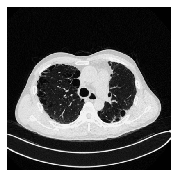

In [6]:
random_img_path = random.choice(all_slices)
random_img_path = '../data/prepared/osic-pulmonary-fibrosis-progression/ID00388637202301028491611/192.npy'
random_img = np.load(str(random_img_path))
print_slice(random_img, figsize=(3,3))

In [7]:
tfm = img_tfm(ToColorTensor())
rgb_img = tfm(random_img)
rgb_img.shape

torch.Size([3, 400, 400])

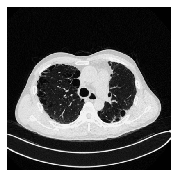

In [8]:
print_slice(rgb_img[0], figsize=(3,3))

## Basic dataset for Contrastive Learning

Generates specified number of slices from one scans per one item. Length of the dataset is equal to the number of scans

In [9]:
# export

class RandomSlicerDataset(Dataset):
    def __init__(self, datasets_root, transform=None, slices_per_scan=4, inter_slice_distance=8):
        scans = list(Path(datasets_root).glob('*/*'))
        #
        # remove from list scans with insufficient number of slices
        self.slices_cache = {}
        for scan_dir in scans:
            slices_files = natsorted(map(str, scan_dir.glob('*.npy')))
            if len(slices_files) > slices_per_scan * inter_slice_distance:
                self.slices_cache[scan_dir] = np.array(slices_files)
            else:
                scans.remove(scan_dir)
        #
        tst_idx = list(range(2, len(scans), 5))
        self.tst_scans = [scans[i] for i in tst_idx]
        trn_idx = set(tst_idx).symmetric_difference(list(range(len(scans))))
        self.trn_scans = [scans[i] for i in trn_idx]
        self.mode = 'trn'
        self.scans = self.trn_scans
        #
        self.consistant_slices = False
        #
        self.transform = transform
        self.slices_per_scan = slices_per_scan
        self.inter_slice_distance = inter_slice_distance
        
        #self.slices_cache = {}

    def set_trn_mode(self):
        self.mode = 'trn'
        self.scans = self.trn_scans
        self.consistant_slices = False

    def set_tst_mode(self):
        self.mode = 'tst'
        self.scans = self.tst_scans
        self.consistant_slices = True


    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.slices_cache:
            slices_files = map(str, scan_dir.glob('*.npy'))

            # natural sorting of files
            self.slices_cache[scan_dir] = np.array(natsorted(slices_files))

        slices_files = self.slices_cache[scan_dir]

        # calculate num of combinations based on total items count, return count and step size
        combinations_n = len(slices_files) - self.inter_slice_distance * (self.slices_per_scan - 1)

        # retrun slices according to config
        idx_first_slice = np.random.randint(combinations_n) if not self.consistant_slices \
            else np.array([ord(c) for c in scan_dir.__str__()]).sum() % combinations_n
        idx_list = idx_first_slice + self.inter_slice_distance * np.arange(self.slices_per_scan)

        random_slices = lmap(np.load, slices_files[idx_list])

        # augment two copies of selected random files
        return self.aug(random_slices), self.aug(random_slices)

    def aug(self, slices):
        if self.transform:
            slices = lmap(self.transform, slices)

        # return np.stack(slices)
        w, h = slices[0].shape
        return np.stack(slices).reshape((len(slices), 1, w, h)).astype(np.float32)



In [10]:
# this just an example
tfms = img_tfm(A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(384, 384)
    #ToColorTensor()
]))

In [11]:
dataset = RandomSlicerDataset(datasets_root, transform=tfms)
len(dataset)

142

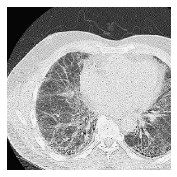

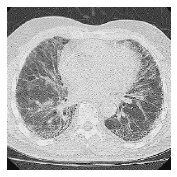

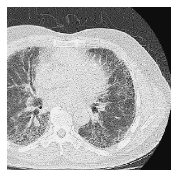

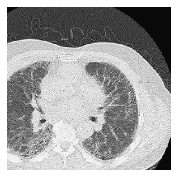

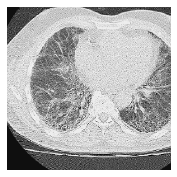

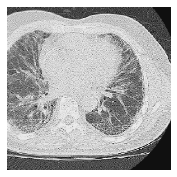

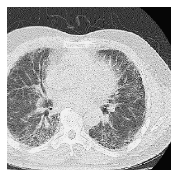

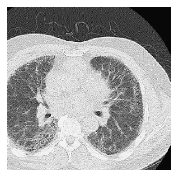

In [29]:
for slice_images in random.choice(dataset):
    for slice_img in slice_images:
        print_slice(slice_img[0], figsize=(3, 3))


#### Checking if caching is working
Enumerating the dicrectory is cached but slices loading is not because datasets are too big

In [19]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 457 ms


In [20]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 487 ms


#### Testing with default dataloader

In [21]:
batch_size = 8

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

#### Optionally we can squash per-scan batches into one batch

In [22]:
# export

# merge list of scans batches into one batch
# [N, M, ...] -> [N * M, ...]
def squash_scan_batches(superbatch):
    shape = np.array(superbatch.shape)
    
    # slices from all scans and all batches go to single batch
    shape[1] = shape[1] * shape[0]
    
    # drop first dimension
    return superbatch.view(*shape[1:])

# split batch of slices from N scans into N per-scan batches
# [N * M, ...] -> [N, M, ...]
def split_scans(superbatch, num_scans, num_slices):
    # add extra dimension
    shape = np.array([0] + list(superbatch.shape))

    shape[:2] = [num_scans, num_slices]

    return superbatch.view(*shape)

In [23]:
for superbatch0, superbatch1 in loader:
    break

In [24]:
src_shape = np.array(superbatch0.shape)

src_shape

array([  8,   4,   1, 384, 384])

In [25]:
reshaped_batch0 = squash_scan_batches(superbatch0)
reshaped_batch1 = squash_scan_batches(superbatch1)
print(reshaped_batch0.shape)

torch.Size([32, 1, 384, 384])


In [26]:
split_scans(reshaped_batch1, src_shape[0], src_shape[1]).shape

torch.Size([8, 4, 1, 384, 384])

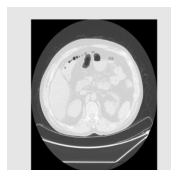

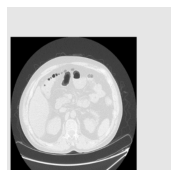

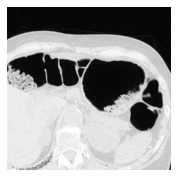

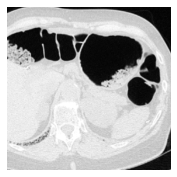

In [27]:
print_slice(superbatch0[0][1][0], figsize=(3, 3))
print_slice(superbatch1[0][1][0], figsize=(3, 3))
print_slice(superbatch0[1][1][0], figsize=(3, 3))
print_slice(superbatch1[1][1][0], figsize=(3, 3))

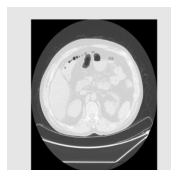

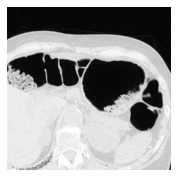

In [28]:
print_slice(reshaped_batch0[1][0], figsize=(3, 3))
print_slice(reshaped_batch0[4 + 1][0], figsize=(3, 3))

## Slice classification dataset

In [27]:
# export

class SliceClassificationDataset(Dataset):
    '''Dataset for per slice classification'''

    def __init__(self, df, root_dir, labels, transform=None):
        super().__init__()
        
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.lbl2code = {k: v for v, k in enumerate(labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        slice_info = self.df.iloc[idx]
        
        image = np.load(self.root_dir / slice_info.path)
        label = slice_info.label

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.lbl2code[label])

In [28]:
cls_ds_root = datasets_root / 'covid19-ct-scans'

In [29]:
df = pd.read_csv(cls_ds_root / 'metadata.csv')
# from sklearn.model_selection import train_test_split
# df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label)

In [31]:
train_ds = SliceClassificationDataset(df, cls_ds_root, transform=tfms)

img, lbl = random.choice(train_ds)

tensor(1, dtype=torch.int8)


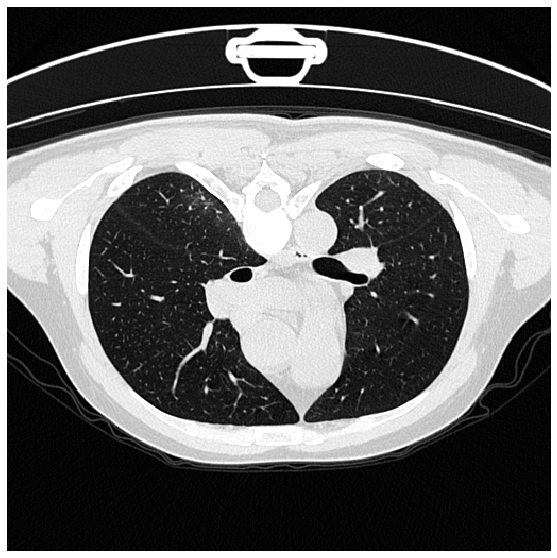

In [21]:
print(lbl)
print_slice(img)

In [33]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

for batch_x, batch_y in train_loader:
    break

batch_y

tensor([1, 0, 1, 0, 1, 1, 1, 1])